In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [43]:
PATH = "data/plant_seedlings_classification"

In [44]:
print(torch.cuda.is_available())

print(torch.backends.cudnn.enabled)

os.listdir(PATH)

True
True


['test', 'sample_submission.csv', 'train']

In [45]:
dirs = os.listdir(f'{PATH}/train')
dirs

['Cleavers',
 'Maize',
 'Fat Hen',
 'Common Chickweed',
 'Black-grass',
 'Charlock',
 'Loose Silky-bent',
 'Small-flowered Cranesbill',
 'Common wheat',
 'Sugar beet',
 'Shepherds Purse',
 'Scentless Mayweed']

In [46]:
files = os.listdir(f'{PATH}/train/Sugar beet')[:5]

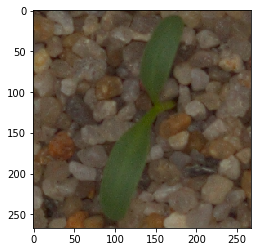

In [47]:
img = plt.imread(f'{PATH}/train/Sugar beet/{files[0]}')

plt.imshow(img)

In [48]:
img.shape

(267, 267, 3)

In [49]:
class_to_count = { classification : len(os.listdir(f'{PATH}/train/{classification}')) for classification in dirs }
class_to_count

{'Cleavers': 287,
 'Maize': 221,
 'Fat Hen': 475,
 'Common Chickweed': 611,
 'Black-grass': 263,
 'Charlock': 390,
 'Loose Silky-bent': 654,
 'Small-flowered Cranesbill': 496,
 'Common wheat': 221,
 'Sugar beet': 385,
 'Shepherds Purse': 231,
 'Scentless Mayweed': 516}

In [82]:
def create_valid_from_train_dir(path, train_dir='train', val_dir='valid'):
    sets_top_level = os.listdir(path)
    if sets_top_level.count(val_dir):
        print(f'Validation directory - {val_dir} - already exists. exiting function')
        return
    
    train_path = f'{path}/{train_dir}'
    valid_path = f'{path}/{val_dir}'
    os.mkdir(valid_path)
    
    classes = os.listdir(f'{path}/{train_dir}')
    class_to_fns = { cls : os.listdir(f'{train_path}/{cls}') for cls in classes }
    class_to_count = { cls : len(fns) for (cls, fns) in class_to_fns.items() }
    class_to_cv_idxs = { cls : get_cv_idxs(cnt).tolist() for (cls, cnt) in class_to_count.items() }
    
    for (cls, cv_idxs) in class_to_cv_idxs.items():
        train_class_path = f'{train_path}/{cls}'
        valid_class_path = f'{valid_path}/{cls}'
        
        os.mkdir(valid_class_path)
        
        fns = class_to_fns[cls]
        fns_to_move = [fns[i] for i in cv_idxs]
        
        for fn in fns_to_move:
            shutil.move(f'{train_class_path}/{fn}', f'{valid_class_path}/{fn}')
        print(f'moved {len(fns_to_move)} out of {len(fns)} files for class: {cls}')

create_valid_from_train_dir(PATH)

moved 57 out of 287 files for class: Cleavers
moved 44 out of 221 files for class: Maize
moved 95 out of 475 files for class: Fat Hen
moved 122 out of 611 files for class: Common Chickweed
moved 52 out of 263 files for class: Black-grass
moved 78 out of 390 files for class: Charlock
moved 130 out of 654 files for class: Loose Silky-bent
moved 99 out of 496 files for class: Small-flowered Cranesbill
moved 44 out of 221 files for class: Common wheat
moved 77 out of 385 files for class: Sugar beet
moved 46 out of 231 files for class: Shepherds Purse
moved 103 out of 516 files for class: Scentless Mayweed


In [83]:
arch=resnet34
sz = 224

data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))

## Initial, naive model

In [88]:
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 3)

epoch      trn_loss   val_loss   accuracy                 
    0      1.533183   0.89103    0.707497  
    1      1.110892   0.724347   0.755016                 
    2      0.889081   0.631211   0.799366                  



[array([0.63121]), 0.7993664204633727]

## Choosing a learning rate

In [92]:
learn = ConvLearner.pretrained(arch, data, precompute=True)
lrf=learn.lr_find()

 52%|█████▏    | 31/60 [00:00<00:01, 28.70it/s, loss=2.79]


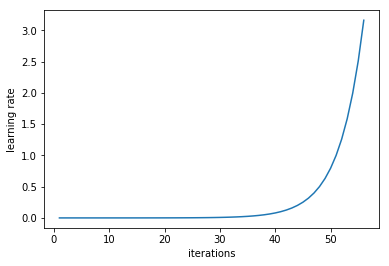

In [93]:
learn.sched.plot_lr()

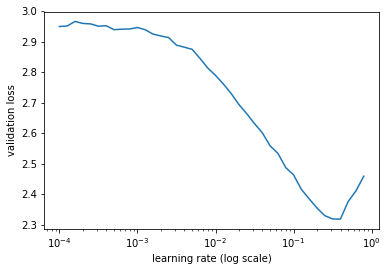

In [94]:
learn.sched.plot()

10^-1 (or maybe 10^(-1.5) = 0.0316 )looks good!

In [156]:
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.0316, 5)

epoch      trn_loss   val_loss   accuracy                 
    0      1.178145   0.597183   0.80359   
    1      0.834699   0.470935   0.846885                  
    2      0.665066   0.438818   0.853221                  
    3      0.57687    0.418626   0.855333                  
    4      0.499351   0.396573   0.859556                  



[array([0.39657]), 0.8595564944439478]

## Data Augmentation

In [226]:
sz=299
tfms = tfms_from_model(resnet34, sz, aug_tfms=[RandomDihedral(), RandomLighting(0.05, 0.05)], max_zoom=1.1)

In [227]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

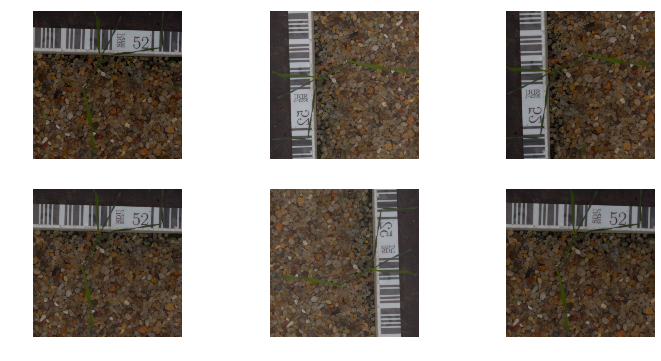

In [228]:
ims = np.stack([get_augs() for i in range(6)])

plots(ims, rows=2)

In [230]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)

In [231]:
learn.fit(0.0316, 1)

epoch      trn_loss   val_loss   accuracy                 
    0      1.418563   0.684838   0.770855  


[array([0.68484]), 0.7708553330699393]

In [232]:
learn.precompute=False

In [234]:
learn.fit(0.0316, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                  
    0      0.802706   0.490176   0.843717  
    1      0.779994   0.456152   0.859556                  
    2      0.758402   0.46487    0.833157                  


[array([0.46487]), 0.833157339342796]

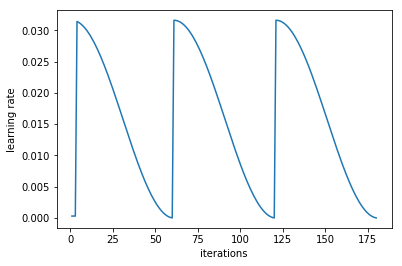

In [235]:
learn.sched.plot_lr()

In [236]:
learn.unfreeze()

In [237]:
lrf=learn.lr_find()

 92%|█████████▏| 55/60 [00:46<00:03,  1.28it/s, loss=3.03]

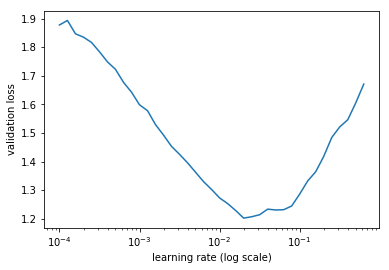

In [238]:
learn.sched.plot()

In [239]:
lr=np.array([0.0003125,0.00125,0.005])

In [ ]:
learn.fit(lr, 4, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                  
    0      0.647981   0.331421   0.878564  
    1      0.451287   0.227042   0.914467                  
    2      0.331681   0.209247   0.92397                   
    3      0.285575   0.187957   0.932418                  
    4      0.241554   0.167314   0.936642                  
    5      0.219535   0.161378   0.942978                  
    6      0.191711   0.159702   0.941922                  
    7      0.199338   0.160809   0.946146                  
    8      0.175363   0.151638   0.93981                   
    9      0.164798   0.138418   0.94509                   
    10     0.146628   0.141805   0.949314                  
    11     0.140387   0.129465   0.955649                  
    12     0.127894   0.127683   0.955649                  
    13     0.12522    0.128703   0.955649                  
 73%|███████▎  | 44/60 [00:36<00:12,  1.30it/s, loss=0.123]

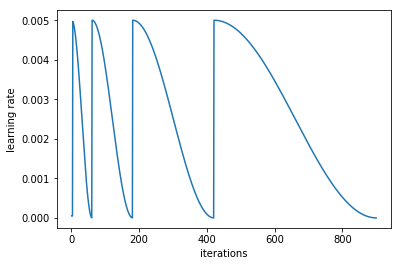

In [218]:
learn.sched.plot_lr()

In [219]:
learn.save('299_all_resnet34_ps05')
